# Time Series Forecasting

In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the dataset

data = pd.read_csv('Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')

data.shape

(144, 1)

In [3]:
#checking the head of the data
data.head()

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0


In [4]:
# checking the tail of the data
data.tail()

,Customers
Date,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0
1960-11-01,750.0
1960-12-01,732.0


## Missing values
Missing data (or missing values) is defined as the data value that is not stored for a variable in the observation of interest.

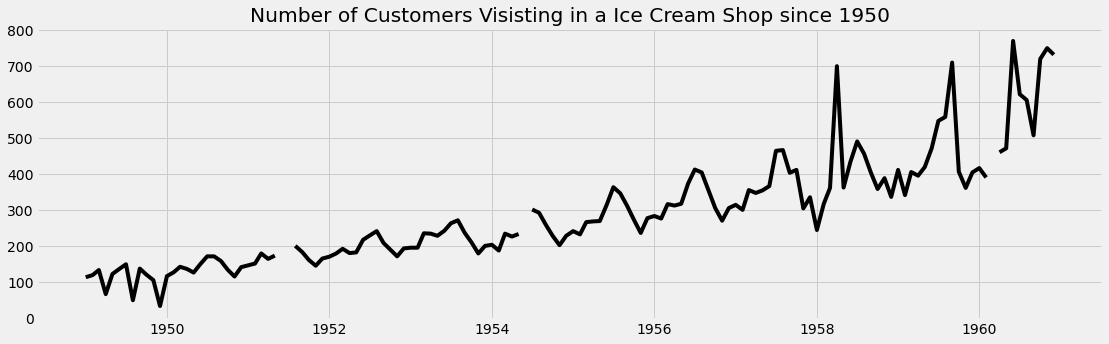

In [5]:
#Checking for the missing values

plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

We can observe from the above plot that there are some missing values in our time series data. We need to impute the missing values of the time series with an appropriate method so that the trend and seasonality of the time series is retained.

## We have the following methods for treating missing values in the time series data.
1)	Mean Imputation

2)	Last Observation Carried forward

3)	Linear Interpolation

4)	Seasonal Interpolation


### 1. Mean Imputation
In this method, we fill the missing values by the mean of the data.

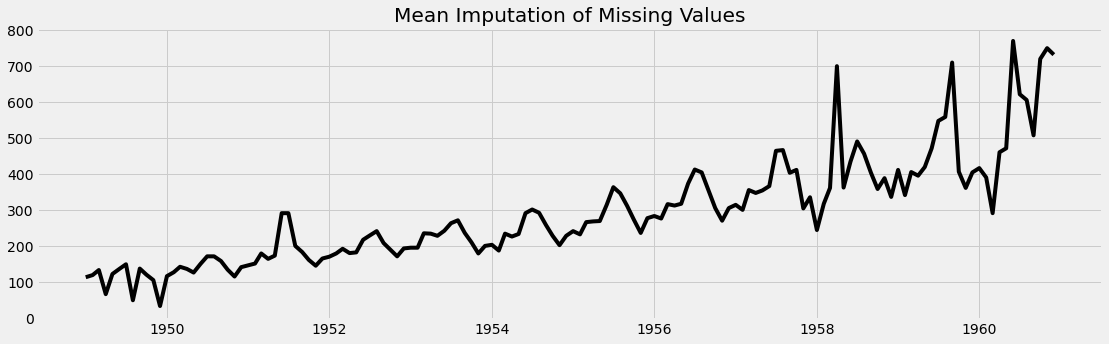

In [6]:
plt.rcParams['figure.figsize']=(17,5)

#filling the missing values with mean
data['Customers_mean'] = data['Customers'].fillna(data['Customers'].mean())
plt.plot(data['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

### 2. Last Observation Carried Forward
In this method, we impute the missing values with previous value in the data.

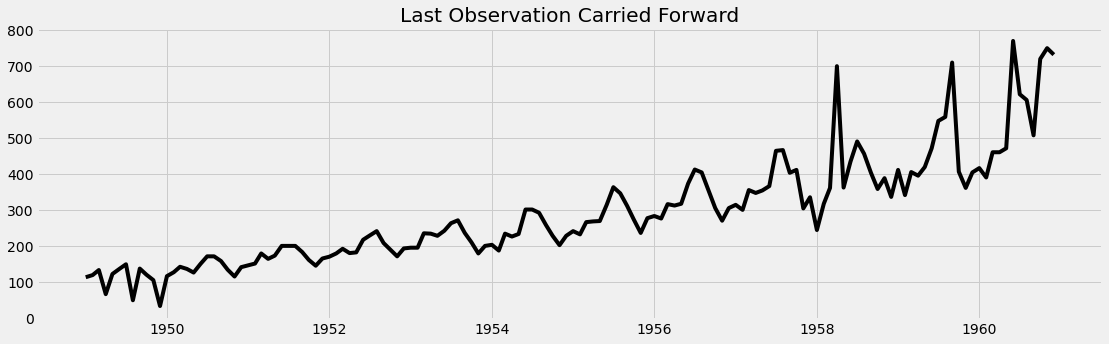

In [7]:
plt.rcParams['figure.figsize']=(17,5)
#filling the missing values with the previous one
data['Customers_mean'] = data['Customers'].bfill()
plt.plot(data['Customers_mean'],color='black')
plt.title("Last Observation Carried Forward")
plt.show()

### 3. Linear Interpolation
In this method, we draw a straight line joining the previous and next points of the missing values.

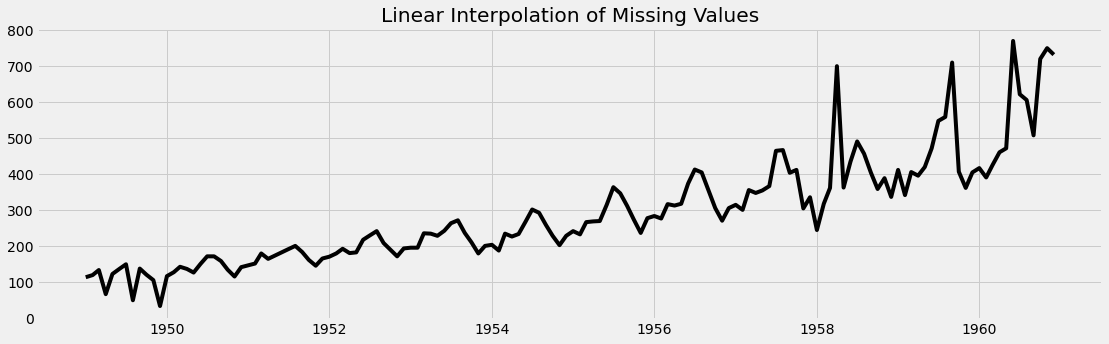

In [8]:
#imputing missing values using Linear Interpolation
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear'] = data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

We can observe that out of all the four method of imputing missing values **Linear Interpolation** works best for this time series retaining the trend as well as the seasonality of the data.
So we proceed with the Linear Interpolation method.

In [9]:
data['Customers'] = data['Customers_linear']  

## Checking for Outliers
## Box plot
It is a standardized way of displaying the distribution of data. Any data points which are **less than Q1-1.5IQR** or **greater than Q3+1.5IQR** are considered to be outliers.

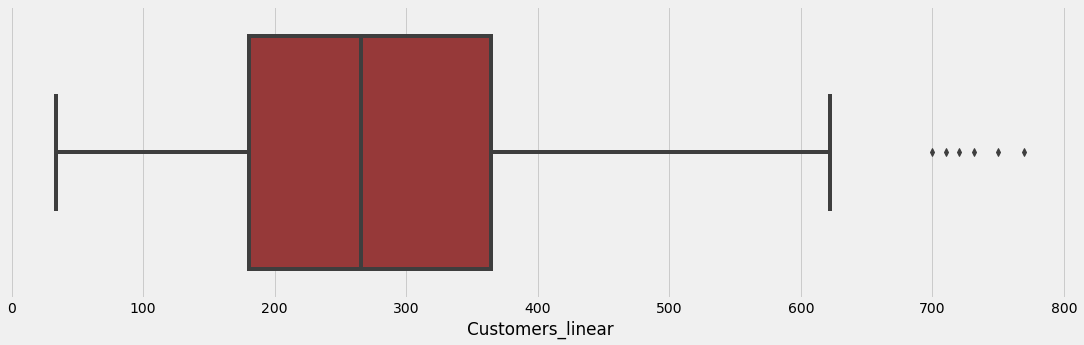

In [10]:
plt.rcParams['figure.figsize']=(17,5)
#checking for outliers using boxplot
sns.boxplot(data['Customers_linear'], color='brown')

We can observe from the above boxplot that the data contains some outliers in it.
There can be some period where the number of customers visiting the shop are quite higher. These points can be useful to us but these are outliers so we cap them to keep them in our observation and get rid of outliers.

In [11]:
# outliers treatment

data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622
# lets also check the null values again
data.isnull().sum()

Customers           0
Customers_mean      0
Customers_linear    0
dtype: int64

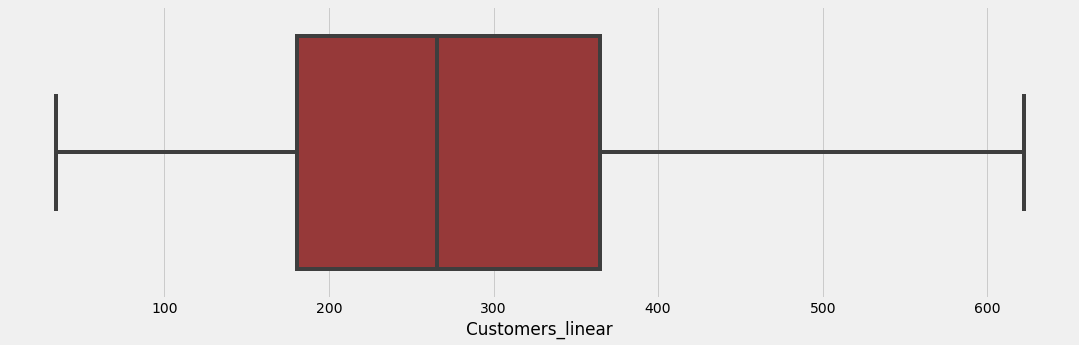

In [12]:
plt.rcParams['figure.figsize']=(17,5)
sns.boxplot(data['Customers_linear'], color='brown')
plt.show()

## Time Series Decomposition

In [13]:
import statsmodels.api as sm

## Multiplicative Seasonal Decomposition
Multiplicative Seasonal decomposition is when we multiply the individual components to get the time series data.

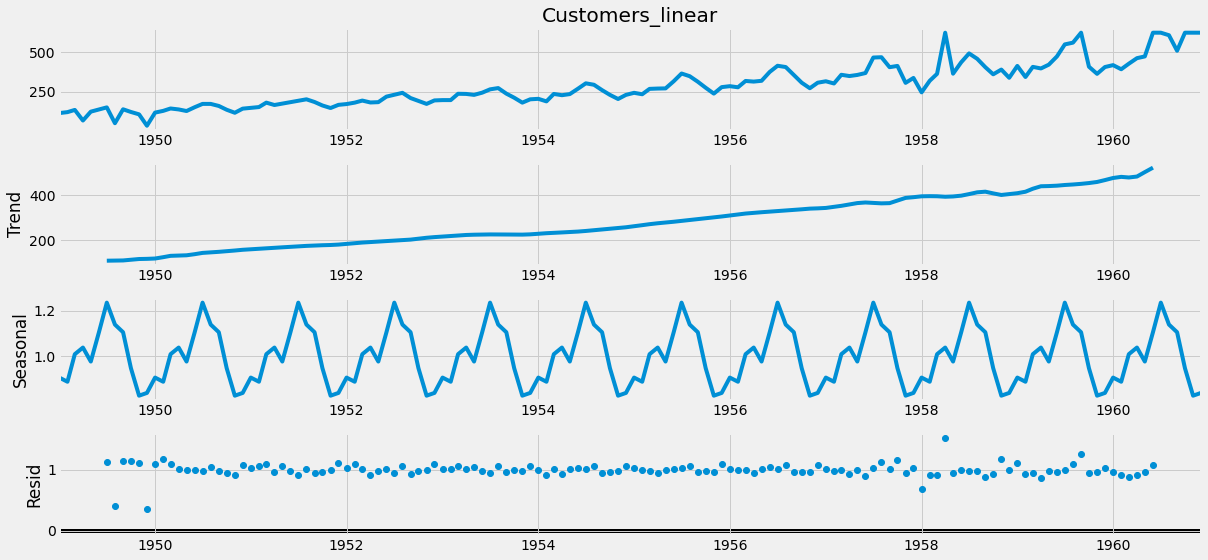

In [14]:
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(data['Customers_linear'], model='multiplicative')
fig = decomposition.plot()
plt.show()

This decomposition looks better than the previous one.
So, we can conclude that the time series is formed by multiplying all the individual components.
So, we need to go for the model which takes care of **Level, Trend and Seasonality**.

We have two such models
1. Holt Winter exponential smoothing.
2. SARIMA Model

## Splitting Train and Test data

In [15]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

In [16]:
# lets check the shape of train

print(train.shape)
train.tail()

(115, 3)


,Customers,Customers_mean,Customers_linear
Date,,,
1958-03-01,362.0,362.0,362.0
1958-04-01,700.0,700.0,622.0
1958-05-01,363.0,363.0,363.0
1958-06-01,435.0,435.0,435.0
1958-07-01,491.0,491.0,491.0


In [17]:
# lets check the shape of test

print(test.shape)
test.head()

(29, 3)


,Customers,Customers_mean,Customers_linear
Date,,,
1958-08-01,457.0,457.0,457.0
1958-09-01,404.0,404.0,404.0
1958-10-01,359.0,359.0,359.0
1958-11-01,389.0,389.0,389.0
1958-12-01,337.0,337.0,337.0


We know 

# Holt Winter Exponential Smoothing
This techniques forecasts based on level, trend and seasonality.
The forecast equation for this method includes seasonality.
	
y(t+1) = l(t)+b(t)+s(t+1-m) 
Here m is the number of time a season repeats in a time period.

In [19]:
#importing ExponentiaSmoothing from time series analysis(tsa)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['Customers'], seasonal_periods=12, trend='multiplicative', seasonal='additive')
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.04)
model_fit.params
y_holtwinter = test.copy()
y_holtwinter['holtwinter_forecast'] = model_fit.forecast(36)

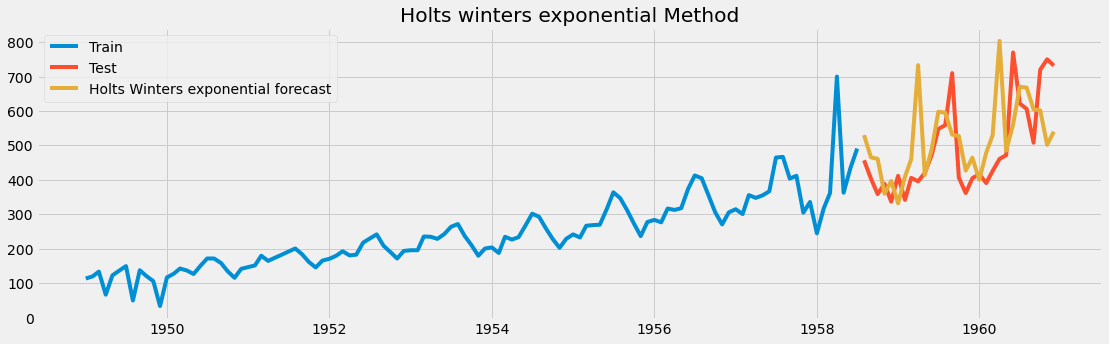

In [20]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_holtwinter['holtwinter_forecast'], label = 'Holts Winters exponential forecast')

plt.legend()
plt.title('Holts winters exponential Method')
plt.show()

In [21]:
# evaluating model 
from sklearn.metrics import mean_squared_error
mfe = np.round(np.mean(test['Customers']-y_holtwinter['holtwinter_forecast']),2)
mae = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])),2)
mape = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])/test['Customers'])*100,2)
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'], y_holtwinter['holtwinter_forecast'])),2)

result = pd.DataFrame({'mfe':mfe,'mae':mae,'mape':mape,'rmse':rmse}, index=[0])
result

,mfe,mae,mape,rmse
0,-26.94,101.23,20.64,133.62


we got good results but let's see if we can improve our forecasted values.
So, next we would use SARIMA Model.
Before using SARIMA model we need to take care of the assumptions of the SARIMA Model.
So, lets check if the time series is stationary or not.

# Stationarity
Stationarity means that the statistical properties of a process generating a time series do not change over time. The statistical properties are Mean, variance and covariance which are same irrespective of the time at which you observe them.

Stationarity is an important concept as stationary processes are easier to analyze and model because their statistical properties do not change over time.



# Augmented Dickey-Fuller Test for Stationarity
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [22]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customers_linear'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: 2.710560011283277
n_lags: 0.9990875034273379
p-value: 0.9990875034273379
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275


* p-value is 1 and its value is larger than 0.05 , hence 
it fails to reject the null hypothesis. Hence, the data has a unit root and is non-stationary

* The mean value is not stationary.
* The variance is fluctating over time.

## Converting Non Stationarity Series into Stationary

we have two method for converting a non stationary series into a stationary series:-
1. Box Cox transformation
2. Differencing

### BOX COX transformation 
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a broader number of tests.

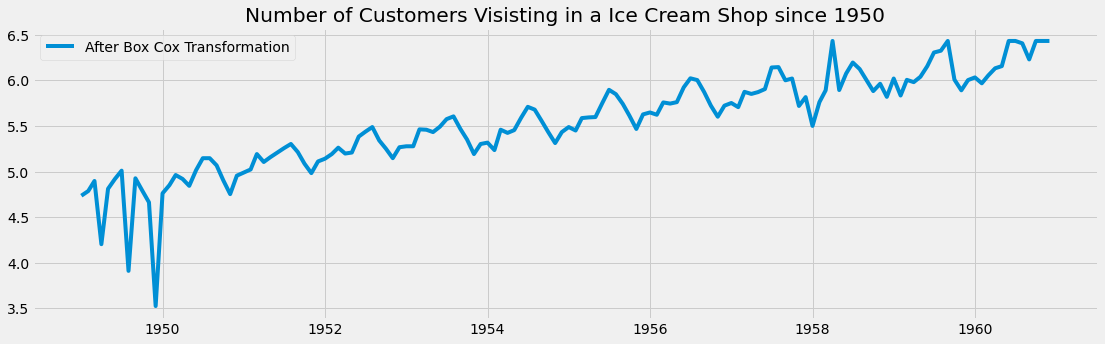

In [23]:
#importing boxcox from scipy
from scipy.stats import boxcox 

#appyling the boxcox transformation with lambda as 0
data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend(loc='best')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Differencing

Differencing stabilises the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. 

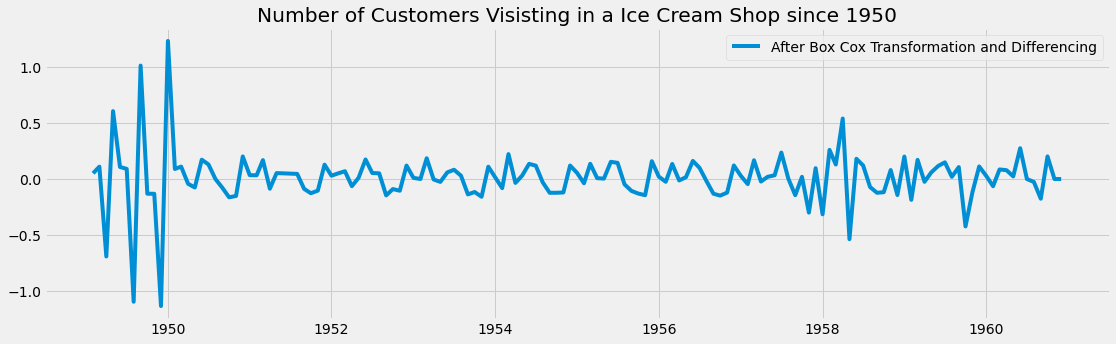

In [24]:
data_boxcox_difference = pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Checking for Stationarity again
Lets check now if the series has been converted to stationary or not.

### ADF Test

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_boxcox_difference, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]:.20f}')
print(f'p-value: {result[1]:.20f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.770270241136213
n_lags: 0.00000000000000000000
p-value: 0.00000000000000000000
Critial Values:
   1%, -3.4808880719210005
Critial Values:
   5%, -2.8836966192225284
Critial Values:
   10%, -2.5785857598714417


p-value is less than 0.05 hence it rejects the Null Hypothesis, hence it is stationary.

## AutoCorrelation Measures
Autocorrelation is the representation of the degree of similarity between a given time series and the lagged version of itself over successive time intervals.

It helps us to know a variable is influenced by its own lagged values.


## AutoCorrelation Function
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. 

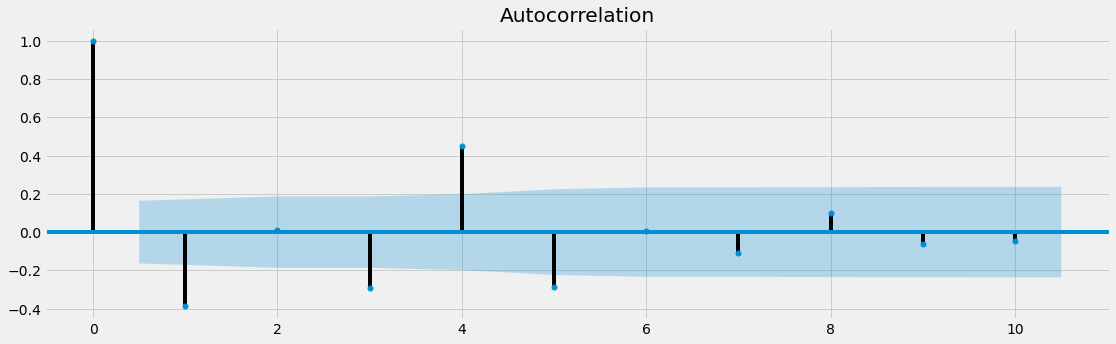

In [26]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

## Partial Auto Correleation Function (PACF)
Partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

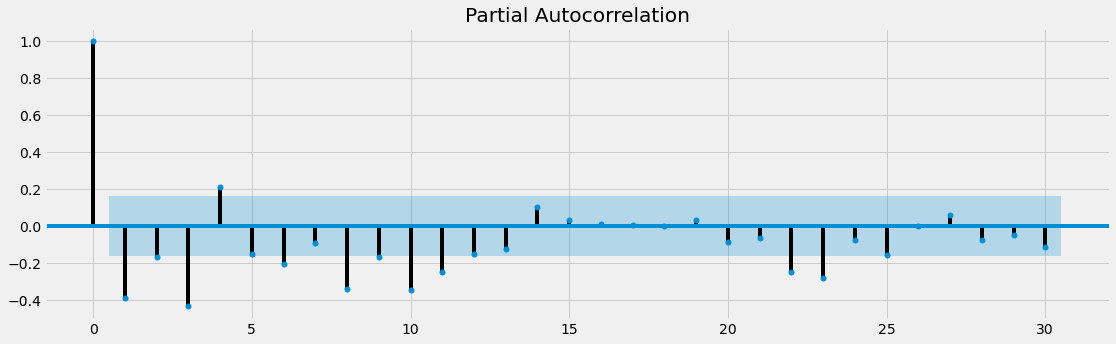

In [27]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

# Splitting into Train and Test data

In [28]:
train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]  

# Seasonal Auto Regressive Integrated Moving Average Model (SARIMA)

SARIMA model brings all the features of ARIMA model along with the seasonality.

The key elements performed in SARIMA are:-

1. The time series is differenced to make it stationary.

2. The SARIMA equation is a linear combination of past observations and past errors.

3. Seasonal differencing is performed on the time series.

4. SARIMA models future seasonality as a linear combination of past seasonality observations and past seasonality errors.


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox_difference, order=(1,1,1), seasonal_order=(1,1,1,6))
model_fit = model.fit()
print(model_fit.params)

ar.L1     -0.577400
ma.L1     -0.998102
ar.S.L6   -0.734099
ma.S.L6   -0.540178
sigma2     0.049827
dtype: float64


## Recover Time Series Data

In [30]:
y_sarima_new = test_data_boxcox_difference.copy()
y_sarima_new['sarima_forecast_boxcox_difference'] = model_fit.predict(test_data_boxcox_difference.index.min(), test_data_boxcox_difference.index.max())
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox_difference'].cumsum()
y_sarima_new['sarima_forecast_boxcox'] = y_sarima_new['sarima_forecast_boxcox'].add(test_data_boxcox[0])
y_sarima_new['sarima_forecast'] = np.exp(y_sarima_new['sarima_forecast_boxcox'])

## Plotting train, test and forecasted data

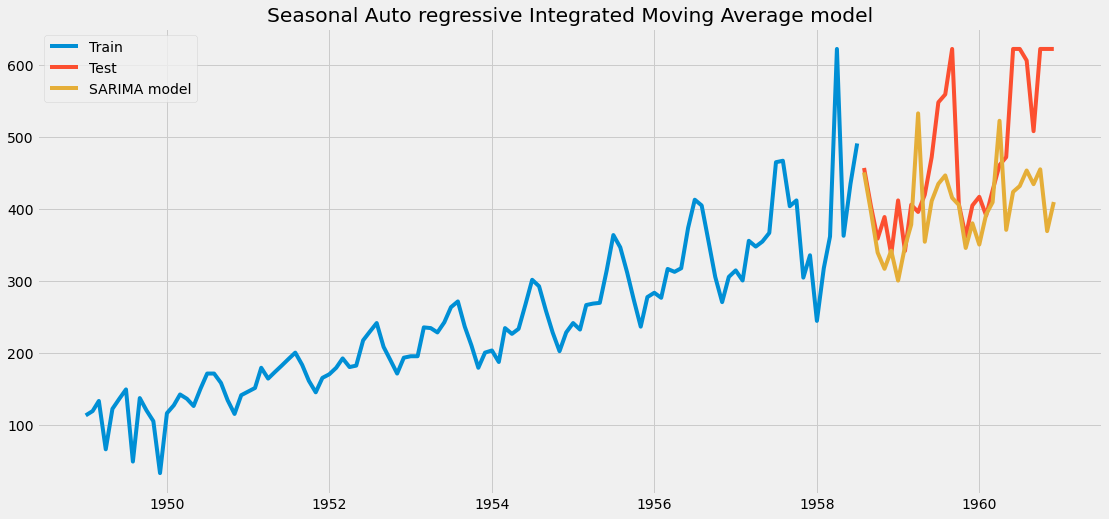

In [31]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_sarima_new['sarima_forecast'][test.index.min():], label = 'SARIMA model')

plt.legend()
plt.title('Seasonal Auto regressive Integrated Moving Average model')
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
mfe = np.round(np.mean(test['Customers']-y_sarima_new['sarima_forecast']),2)
mae = np.round(np.mean(np.abs(test['Customers']-y_sarima_new['sarima_forecast'])),2)
mape = np.round(np.mean(np.abs(test['Customers']-y_sarima_new['sarima_forecast'])/test['Customers'])*100,2)
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'],y_sarima_new['sarima_forecast'])),2)

result = pd.DataFrame({'mfe':mfe,'mae':mae,'mape':mape, 'rmse':rmse}, index=[0])
result

,mfe,mae,mape,rmse
0,90.79,105.37,17.99,153.17


In [33]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'